### Imports and function definitions

In [1]:
import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds
import pandas as pd

from IPython import display

tensorflow version:  2.4.1


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2
GPUs:  2


### Ways to iterate over the dataset

### Load and Prepare the Dataset / Preprocessing Functions

In [84]:
# From https://www.tensorflow.org/datasets/keras_example

(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    'celeb_a',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def preprocess(data):
    """Normalizes images: `uint8` -> `float32`."""
    image = data['image']
    label = data['attributes']
    image = tf.image.resize(image, [28, 28])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

ds_train = ds_train_raw.map(
    preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [85]:
ds_train

<PrefetchDataset shapes: ((None, 28, 28, 3), {5_o_Clock_Shadow: (None,), Arched_Eyebrows: (None,), Attractive: (None,), Bags_Under_Eyes: (None,), Bald: (None,), Bangs: (None,), Big_Lips: (None,), Big_Nose: (None,), Black_Hair: (None,), Blond_Hair: (None,), Blurry: (None,), Brown_Hair: (None,), Bushy_Eyebrows: (None,), Chubby: (None,), Double_Chin: (None,), Eyeglasses: (None,), Goatee: (None,), Gray_Hair: (None,), Heavy_Makeup: (None,), High_Cheekbones: (None,), Male: (None,), Mouth_Slightly_Open: (None,), Mustache: (None,), Narrow_Eyes: (None,), No_Beard: (None,), Oval_Face: (None,), Pale_Skin: (None,), Pointy_Nose: (None,), Receding_Hairline: (None,), Rosy_Cheeks: (None,), Sideburns: (None,), Smiling: (None,), Straight_Hair: (None,), Wavy_Hair: (None,), Wearing_Earrings: (None,), Wearing_Hat: (None,), Wearing_Lipstick: (None,), Wearing_Necklace: (None,), Wearing_Necktie: (None,), Young: (None,)}), types: (tf.float32, {5_o_Clock_Shadow: tf.bool, Arched_Eyebrows: tf.bool, Attractive: tf

In [86]:
for images, attributes in ds_train:
    break
print(images.shape)
print(attributes.keys())

(128, 28, 28, 3)
dict_keys(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'])


In [87]:
images.numpy().max()

1.0

## Create the models

### Generator

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

In [88]:
# Add attribute vectors
#attributes.items()

In [89]:
label = layers.Input(shape=(1,))
#label_embedding = layers.Flatten()(layers.Embedding(40, 100)(label))
label_embedding = layers.Embedding(40, 100)(label)
print(label_embedding)
n_nodes = 7 * 7
li = layers.Dense(n_nodes)(label_embedding)
print(li)
li = layers.Reshape((7,7,1))(li)
print(li)
noise = layers.Input(shape=(100,))
model_input = layers.multiply([noise, label_embedding])
print(model_input)
print(noise.shape)
print(label_embedding.shape)

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 100), dtype=tf.float32, name=None), name='embedding_15/embedding_lookup/Identity_1:0', description="created by layer 'embedding_15'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 49), dtype=tf.float32, name=None), name='dense_12/BiasAdd:0', description="created by layer 'dense_12'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1), dtype=tf.float32, name=None), name='reshape_5/Reshape:0', description="created by layer 'reshape_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 100), dtype=tf.float32, name=None), name='multiply_8/mul:0', description="created by layer 'multiply_8'")
(None, 100)
(None, 1, 100)


In [90]:
# Create random values to be multiple with random attributes to form noise for generator input
noise_dim = 100
attribute_embeddings = tf.Variable(initial_value=tf.random.normal([40, noise_dim]), trainable=True)
print(attribute_embeddings.shape)
attributes_random = np.random.choice(a=[False, True], size=(128,40))
# convert from bool
attributes_random = tf.where(batch_attributes_as_bool_tensor, 1.,-1.)
print(attributes_random.shape)

# Create noise vector
attributes_noise = tf.matmul(attributes_random, attribute_embeddings)
print(attributes_noise.shape)

(40, 100)
(128, 40)
(128, 100)


In [91]:
batch_attributes_as_bool_tensor = tf.transpose(tf.stack(list(attributes.values())))
print(batch_attributes_as_bool_tensor.shape)
batch_attributes_as_float_tensor = tf.where(batch_attributes_as_bool_tensor, 1.,-1.)
print(batch_attributes_as_float_tensor.shape)
print(tf.matmul(batch_attributes_as_float_tensor, w))

(128, 40)
(128, 40)
tf.Tensor(
[[-6.0415822e-01  2.3483782e+00 -6.1192346e+00 ... -7.5315247e+00
   5.7591248e-01  4.7875252e+00]
 [-2.2849941e+00 -7.9709826e+00  8.0191412e+00 ...  2.1222115e-01
   3.5325527e+00 -1.2836906e+01]
 [ 3.4128153e-01 -4.4279046e+00 -3.6804023e+00 ...  6.4892993e+00
  -9.7463131e-03 -1.5886521e-01]
 ...
 [ 2.8507624e+00 -8.1133251e+00  6.5942926e+00 ... -1.4398646e+00
  -1.2198657e+00 -2.7325857e-01]
 [-5.3345881e+00 -7.4107547e+00 -1.6881127e+00 ...  3.6136572e+00
   7.0174637e+00 -1.4171443e+00]
 [-5.5320973e+00 -1.4913039e+01  7.7981815e+00 ... -1.2069899e+00
  -4.4922709e+00 -1.2054543e+01]], shape=(128, 100), dtype=float32)


In [92]:
attributes.keys()

dict_keys(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'])

In [115]:
# The generator
def make_generator_model():
    
    model = tf.keras.Sequential(name='Generator')
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    # Output layer
    model.add(layers.Conv2D(3, (3,3), activation='sigmoid', padding = 'same'))
    assert model.output_shape == (None, 28, 28, 3)

    return model

<dtype: 'float32'>
(1, 28, 28, 3)


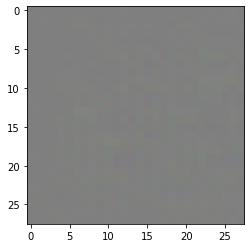

In [94]:
# Create an image using the untrained generator
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.dtype)
print(generated_image.shape)

#plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.imshow(generated_image[0])

None

(40, 100)
(128, 40)
(128, 100)
<dtype: 'float32'>
(128, 28, 28, 3)


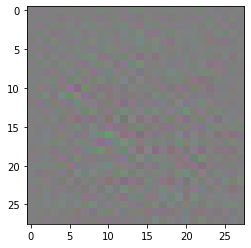

In [97]:
# Create random values to be multiple with random attributes to form noise for generator input
noise_dim = 100
attribute_embeddings = tf.Variable(initial_value=tf.random.normal([40, noise_dim]), trainable=True)
print(attribute_embeddings.shape)
attributes_random = np.random.choice(a=[False, True], size=(128,40))
# convert from bool
attributes_random = tf.where(batch_attributes_as_bool_tensor, 1.,-1.)
print(attributes_random.shape)

# Create noise vector
attributes_noise = tf.matmul(attributes_random, attribute_embeddings)
print(attributes_noise.shape)

generator = make_generator_model()
generated_image = generator(attributes_noise, training=False)
print(generated_image.dtype)
print(generated_image.shape)

plt.imshow(generated_image[1])

None

### Discriminator

The discriminator is a CNN-based image classifier.

In [98]:
def make_discriminator_model():
    
    # label input
    input_label = layers.Input(shape=(100))
    input_image = layers.Input(shape=(28,28,3))
    
    
    conv_model = tf.keras.Sequential()
    # downsample
    conv_model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    conv_model.add(layers.LeakyReLU())
    conv_model.add(layers.Dropout(0.3))
    
    #downsample
    conv_model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    conv_model.add(layers.LeakyReLU())
    conv_model.add(layers.Dropout(0.3))
    
    # classifier
    conv_model.add(layers.Flatten())
    
    # Concatentate the new one here
    # The feed the concatenated model into the dense layer
    img_feature_vec = conv_model(input_image)
    
    # concat label as a channel
    merge = layers.Concatenate()([img_feature_vec, input_label])
    
    output = layers.Dense(1)(merge)
    
    # Need to create new model here with correct shapes which need to be defined as inputs
    model = tf.keras.Model([input_image, input_label], output, name='Discriminator')

    return model

In [99]:
# Classify the generated images as real or fake using the discriminator.
# Model is trained to output positive values for real images and negative values for fake images
discriminator = make_discriminator_model()
noise_dim = 100
attribute_embeddings = tf.Variable(initial_value=tf.random.normal([40, noise_dim]), trainable=True) # Do this once only, but add to optimizers
attribute_input = tf.matmul(batch_attributes_as_float_tensor, attribute_embeddings)
decision = discriminator((generated_image, attribute_input))
print (decision)

tf.Tensor(
[[-2.5268018 ]
 [-1.722724  ]
 [-2.80075   ]
 [-2.5687358 ]
 [-2.4523268 ]
 [-0.43573385]
 [-2.3641057 ]
 [-2.5501683 ]
 [-0.6185611 ]
 [-2.4500074 ]
 [-2.3545105 ]
 [-3.5077615 ]
 [-1.6372262 ]
 [-1.719751  ]
 [-1.483567  ]
 [-1.5492327 ]
 [-1.0974221 ]
 [-3.5723221 ]
 [-1.9459847 ]
 [-3.4670868 ]
 [-3.43398   ]
 [-3.397662  ]
 [-2.2388034 ]
 [-4.141769  ]
 [-3.5859084 ]
 [-3.698915  ]
 [-2.73829   ]
 [-2.2685215 ]
 [-3.1776695 ]
 [-3.5180497 ]
 [-3.4780698 ]
 [-3.0454314 ]
 [-2.726102  ]
 [-2.5838962 ]
 [-2.957208  ]
 [-2.4681735 ]
 [-3.762165  ]
 [-3.990175  ]
 [-2.3009787 ]
 [-3.6645443 ]
 [-1.7449939 ]
 [-2.5985103 ]
 [-4.066562  ]
 [-2.2158766 ]
 [-2.0483239 ]
 [-3.013644  ]
 [-3.6619725 ]
 [-3.2803226 ]
 [-3.0336432 ]
 [-2.9017072 ]
 [-1.963032  ]
 [-3.6841145 ]
 [-2.5168672 ]
 [-3.22953   ]
 [-3.3691182 ]
 [-2.925443  ]
 [-3.0127866 ]
 [-3.3685055 ]
 [-2.8394055 ]
 [-2.679134  ]
 [-3.4458487 ]
 [-2.521742  ]
 [-3.0002565 ]
 [-3.285975  ]
 [-2.4257603 ]
 [-3.2758522 ]

## Define the loss and optimisers

In [100]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

Quantifies how well the discriminator is able to distinguish real images from fakes.  

It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s

In [101]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

Quantifies how well it was able to trick the discriminator.  

If the generator is performng well, the discriminator will classify the fake images as real (or 1). This function compares the discriminators decisions on the generated images to an array of 1s

In [102]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimisers

Two different optimisers required since the two networks are trained separately

In [103]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [104]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training Loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [105]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier) to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [118]:
@tf.function
def train_step(images, attributes):
    #noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #TODO put next three lines in function
        batch_attributes_as_bool_tensor = tf.transpose(tf.stack(list(attributes.values())))
        batch_attributes_as_float_tensor = tf.where(batch_attributes_as_bool_tensor, 1.,-1.)
        attribute_input = tf.matmul(batch_attributes_as_float_tensor, attribute_embeddings)
        
        generated_images = generator(attribute_input, training=True)

        real_output = discriminator((images, attribute_input), training=True)
        fake_output = discriminator((generated_images, attribute_input), training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables + [attribute_embeddings])
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables + [attribute_embeddings])

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables + [attribute_embeddings]))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables + [attribute_embeddings]))
    
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch, attribute_batch in dataset:
            train_step(image_batch, attribute_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)
    
# Generate and save images
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False. This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.imshow(predictions[0])
        plt.axis('off')

    image_folder = 'generated_images/'
    image_filepath = image_folder + 'image_at_epoch_{:04d}.png'
    plt.savefig(image_filepath.format(epoch))
    plt.show()


## Train the model

Generator and discriminator are trained simultaneously.  

It is important that the generator and discriminator do not overpower each other (i.e. they train at a similar rate)

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

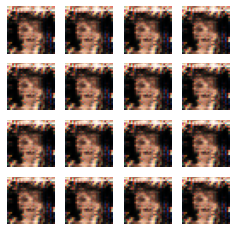

Time for epoch 38 is 43.61782383918762 sec


In [ ]:
#train(train_dataset, EPOCHS)
BATCH_SIZE = 256
train(ds_train, EPOCHS)

## Create a GIF

In [37]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

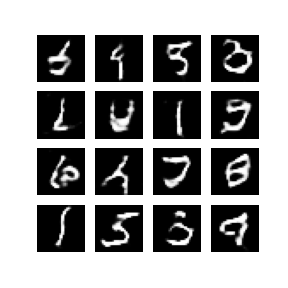

In [38]:
display_image(EPOCHS)